<a href="https://colab.research.google.com/github/mr-alamdari/Generative-Adversarial-Networks-Pytorch/blob/main/Generative_Adversarial_Networks_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
import os
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import PIL 
import torch
import torchvision
import torchsummary

#1.Data

In [2]:
path2data = '/content/data'
os.makedirs(path2data, exist_ok=True)

In [3]:
h, w = 64, 64
mean = (0.485, 0.456, 0.406)
std = (0.5, 0.5, 0.5)
transform = torchvision.transforms.Compose([
            torchvision.transforms.Resize((h, w)),
            torchvision.transforms.CenterCrop((h, w)),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize(mean, std)])

In [4]:
from torchvision.transforms import transforms
train_ds = torchvision.datasets.STL10(path2data,
                                      split='train',
                                      download=True,
                                      transform=transform)

  0%|          | 0/2640397119 [00:00<?, ?it/s]

Extracting /content/data/stl10_binary.tar.gz to /content/data


In [5]:
for x, _ in train_ds:
  print(x.shape, torch.min(x), torch.max(x))
  break

torch.Size([3, 64, 64]) tensor(-0.7975) tensor(1.0253)


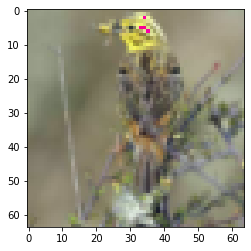

In [6]:
plt.imshow(torchvision.transforms.functional.to_pil_image(0.5*x + 0.5))

In [7]:
# If you run into memory errors when training a model, try reducing the batch size.
train_dl = torch.utils.data.DataLoader(train_ds, 
                                   batch_size=32, 
                                   shuffle=True)

In [8]:
for x, y in train_dl:
  print(x.shape, y.shape)
  break

torch.Size([32, 3, 64, 64]) torch.Size([32])


#2.Generator & Discriminator

###The GAN framework is based on the competition of two models, namely, the generator and discriminator.
#####The generator generates fake images and the discriminator tries to identify real images from fakes images.
###As a result of this competition, the generator will generate better-looking fake images while the discriminator will become better at identifying them.

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

##Generator

In [10]:
class Generator(torch.nn.Module):
  
  def __init__(self, params):
    super(Generator, self).__init__()
    nz = params['nz']   # Noise Vector Size
    ngf = params['ngf'] # Number of convolutional filters in the Generator
    noc = params['noc'] # number of output channles

    #ConvTranspose2d is called a fractionally-strided convolution or deconvolution.
    #it is used to upsample the input vector to the desired iutput size.

    self.dconv1 = torch.nn.ConvTranspose2d(nz, ngf*8, kernel_size=4, stride=1, padding=0, bias=False)
    self.bn1 = torch.nn.BatchNorm2d(ngf*8)
    
    self.dconv2 = torch.nn.ConvTranspose2d(ngf*8, ngf*4, kernel_size=4, stride=2, padding=1, bias=False)
    self.bn2 = torch.nn.BatchNorm2d(ngf*4)
    
    self.dconv3 = torch.nn.ConvTranspose2d(ngf*4, ngf*2, kernel_size=4, stride=2, padding=1, bias=False)
    self.bn3 = torch.nn.BatchNorm2d(ngf*2)
    
    self.dconv4 = torch.nn.ConvTranspose2d(ngf*2, ngf, kernel_size=4, stride=2, padding=1, bias=False)
    self.bn4 = torch.nn.BatchNorm2d(ngf)

    self.dconv5 = torch.nn.ConvTranspose2d(ngf, noc, kernel_size=4, stride=2, padding=1, bias=False)

  def forward(self, x):
    x = self.dconv1(x)
    x = self.bn1(x)
    x = torch.nn.functional.relu(x)

    x = self.dconv2(x)
    x = self.bn2(x)
    x = torch.nn.functional.relu(x)

    x = self.dconv3(x)
    x = self.bn3(x)
    x = torch.nn.functional.relu(x)

    x = self.dconv4(x)
    x = self.bn4(x)
    x = torch.nn.functional.relu(x)

    x = self.dconv5(x)
    x = torch.tanh(x)

    return x

In [11]:
params_gen = {'nz': 100, 'ngf': 64, 'noc':3}

model_gen = Generator(params_gen)
model_gen = model_gen.to(device)

In [12]:
print(model_gen)

Generator(
  (dconv1): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dconv2): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dconv3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dconv4): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dconv5): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
)


In [13]:
with torch.no_grad():
  r = model_gen(torch.zeros(1, 100, 1, 1, device=device))
print(r.shape)

torch.Size([1, 3, 64, 64])


##Discriminator

In [14]:
class Discriminator(torch.nn.Module):
  def __init__(self, params):
    super(Discriminator, self).__init__()
    nic = params['nic']
    ndf = params['ndf']
    self.conv1 = torch.nn.Conv2d(nic, ndf, kernel_size=4, stride=2, padding=1, bias=False)
    self.conv2 = torch.nn.Conv2d(ndf, ndf*2, kernel_size=4, stride=2, padding=1, bias=False)
    self.bn2 = torch.nn.BatchNorm2d(ndf*2)
    
    self.conv3 = torch.nn.Conv2d(ndf*2, ndf*4, kernel_size=4, stride=2, padding=1, bias=False)
    self.bn3 = torch.nn.BatchNorm2d(ndf*4)
    
    self.conv4 = torch.nn.Conv2d(ndf*4, ndf*8, kernel_size=4, stride=2, padding=1, bias=False)
    self.bn4 = torch.nn.BatchNorm2d(ndf*8)
    
    self.conv5 = torch.nn.Conv2d(ndf*8, 1, kernel_size=4, stride=1, padding=0, bias=False)

  def forward(self, x):
    x = self.conv1(x)
    x = torch.nn.functional.leaky_relu(x, 0.2, inplace=True)
    
    x = self.conv2(x)
    x = self.bn2(x)
    x = torch.nn.functional.leaky_relu(x, 0.2, inplace=True)

    x = self.conv3(x)
    x = self.bn3(x)
    x = torch.nn.functional.leaky_relu(x, 0.2, inplace=True)

    x = self.conv4(x)
    x = self.bn4(x)
    x = torch.nn.functional.leaky_relu(x, 0.2, inplace=True)

    x = self.conv5(x)
    x = torch.sigmoid(x)

    return x.view(-1)

In [15]:
params_dis = {'nic':3, 'ndf':64}
model_dis = Discriminator(params_dis)
model_dis = model_dis.to(device)

In [16]:
print(model_dis)

Discriminator(
  (conv1): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
)


In [17]:
with torch.no_grad():
  e = model_dis(torch.zeros(1, 3, h, w, device=device))
print(e.shape)

torch.Size([1])


In [18]:
def initialize_weights(model):
  classname = model.__class__.__name__
  if classname.find('Conv') != -1:
    torch.nn.init.normal_(model.weight.data, 0.0, 0.02) #mean=0.0, std=0.02 ==> Normal Distribution
  elif classname.find('BatchNorm') != -1:
    torch.nn.init.normal_(model.weight.data, 1.0, 0.02)
    torch.nn.init.constant_(model.bias.data, 0)

In [19]:
model_gen.apply(initialize_weights)
model_dis.apply(initialize_weights)

Discriminator(
  (conv1): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
)

#Training the Model

###Training the GAN framework is done in two stages: training the discriminator and training the generator. To this end, we will take the following steps:
####1. Get a batch of real images with the target labels set to 1.
####2. Generate a batch of fake images using the generator with the target labels set to 0.
####3. Feed the mini-batches to the discriminator and compute the loss and gradients.
####4. Update the discriminator parameters using the gradients.
####5. Generate a batch of fake images using the generator with the target labels set to 1.
####6. Feed the fake mini-batch to the discriminator and compute the loss and gradients.
####7.Update the generator only based on gradients.
####8. Repeat from step 1.


In [20]:
loss_func = torch.nn.BCELoss()
lr = 2e-4
beta1 =0.5
opt_dis = torch.optim.Adam(model_dis.parameters(), lr=lr, betas=(beta1, 0.999))
opt_gen = torch.optim.Adam(model_gen.parameters(), lr=lr, betas=(beta1, 0.999))

In [21]:
real_label = 1
fake_label = 0
num_epochs = 2
nz = params_gen['nz']
loss_history = {'gen': [], 'dis': []}

In [22]:
batch_size=0

for epoch in range(num_epochs):
  for batch_count, (x, y) in enumerate(train_dl):
    ba_si = x.size(0)
    model_dis.zero_grad()
    x = x.to(device)
    y = torch.full((ba_si,), real_label, device=device, dtype=torch.float)
    out_dis = model_dis(x)
    loss_r = loss_func(out_dis, y)
    loss_r.backward()

    noise = torch.randn(ba_si, nz, 1, 1, device=device)
    out_gen = model_gen(noise)
    out_dis = model_dis(out_gen.detach())
    y.fill_(fake_label)
    loss_f = loss_func(out_dis, y)
    loss_f.backward()
    loss_dis = loss_r + loss_f
    opt_dis.step()

    model_gen.zero_grad()
    y.fill_(real_label)
    out_dis = model_dis(out_gen)
    loss_gen = loss_func(out_dis, y)
    loss_gen.backward()
    opt_gen.step()

    loss_history['gen'].append(loss_gen.item())
    loss_history['dis'].append(loss_dis.item())
    if batch_count+1/50 == 0:
      print(f'Batch:{batch_count+1} in Epoch:{epoch+1}/{num_epochs}, Generator Loss: {loss_gen.item():.4f}, Discriminator Loss: {loss_dis.item():.4f} ')

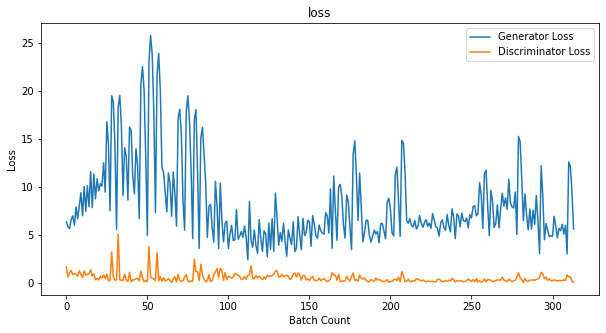

In [23]:
plt.figure(figsize=(10, 5))
plt.title('loss')
plt.plot(loss_history['gen'], label='Generator Loss')
plt.plot(loss_history['dis'], label='Discriminator Loss')
plt.xlabel('Batch Count')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [24]:
path2models = '/content/models/'
os.makedirs(path2models, exist_ok=True)
torch.save(model_gen.state_dict(), f'{path2models}/weights_gen.pt')
torch.save(model_dis.state_dict(), f'{path2models}/weights_dis.pt')

#Deploying Generator

In [ ]:
model_gen.load_state_dict(torch.load(f'{path2models}/weights_gen.pt'))

<All keys matched successfully>

In [ ]:
model_gen.eval()
with torch.no_grad():
  fixed_noise = torch.randn(16, nz, 1, 1, device=device)
  print(fixed_noise.shape)
  img_fake = model_gen(fixed_noise).detach().cpu()

print(img_fake.shape)

torch.Size([16, 100, 1, 1])
torch.Size([16, 3, 64, 64])


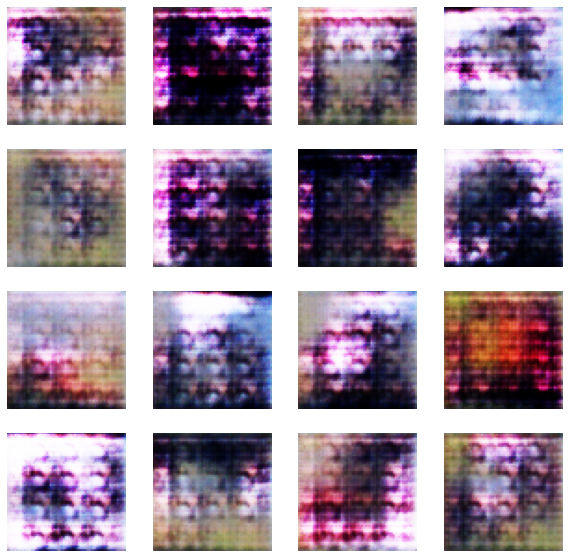

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(16):
  plt.subplot(4, 4, i+1)
  plt.imshow(torchvision.transforms.functional.to_pil_image(0.5 * img_fake[i] + 0.5))
  plt.axis('off')

#Adversarial Examples (Attacks)
###It is a type of input data that can significantly change the model prediction without being noticeable to the human eye.So they can be worrisome, especially in critical tasks such as the security or healthcare domains.
###It would be beneficial to learn how these attacks work in order to start thinking about possible solutions

In [30]:
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive'
!kaggle competitions download -c histopathologic-cancer-detection
!unzip \*.zip && rm *.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/fa2c546059bd262cbe954dfdba24dc0d67f598b0.tif  
  inflating: train/fa2c657eff58b6802cb32843caa2fac25b67c2c9.tif  
  inflating: train/fa2c775c4457d0aeb7e57216849eef5f4e72e566.tif  
  inflating: train/fa2c77e1707c2fe7b0016e00736fb6e4b7f09488.tif  
  inflating: train/fa2ce5e802dd281bd98fcfb538e80b9c96c2b7af.tif  
  inflating: train/fa2d24e4a109d2d3a925890aaed4e0f038dfffb0.tif  
  inflating: train/fa2d7e4865aa7869d2dd85116323b8405c94f1c2.tif  
  inflating: train/fa2d8b2e4acf46e278e2e7acbc034c263d970737.tif  
  inflating: train/fa2df9148831509a181797db79eb1a7bf39593f1.tif  
  inflating: train/fa2e6db0b35484797f58005e3a6e24ca75fbca76.tif  
  inflating: train/fa2e80e84594465329bdc0c8d1b3a507275fbb4d.tif  
  inflating: train/fa2eaf8ec6267fa928a88775dc15ee25b633c537.tif  
  inflating: train/fa2ebf31ff5954570526d4835ac5368fabc1f035.tif  
  inflating: train/fa2efd2dda5235a3e397ea0dd637ea13a78f7599.tif  
  inflating: train/fa2f1d

In [31]:
torch.manual_seed(32)

class HistoCancerDataset(torch.utils.data.Dataset):
  def __init__(self, data_dir, transform, data_type='train'):
    self.data_type = data_type
    path2data = os.path.join(data_dir, self.data_type)
    filenames = os.listdir(path2data)
    self.full_filenames = [os.path.join(path2data, f) for f in filenames]

    if self.data_type == 'train':
      path2csvLabels = os.path.join(data_dir, f'{self.data_type}_labels.csv')
      labels_df = pd.read_csv(path2csvLabels)
      labels_df.set_index('id', inplace=True)
      self.labels = [labels_df.loc[f_name[:-4]].values[0] for f_name in filenames]
    self.transform = transform
  
  def __len__(self):
    return len(self.full_filenames)

  def __getitem__(self, idx):
    image = PIL.Image.open(self.full_filenames[idx])
    image = self.transform(image)
    if self.data_type == 'train':
      return image, self.labels[idx]
    return image

data_dir = "/content/"
data_transformer = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])   
hist_ds = HistoCancerDataset(data_dir, data_transformer, "train")

test_index = np.random.randint(hist_ds.__len__(),size= 100)
test_ds = torch.utils.data.Subset(hist_ds,test_index)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=1, shuffle=False)  

In [35]:
def findConv2dOutShape(h_in, w_in, conv,pool=2):
  kernel_size = conv.kernel_size
  stride = conv.stride
  padding = conv.padding
  dilation = conv.dilation
  h_out = np.floor((h_in + (2*padding[0]) - dilation[0]*(kernel_size[0]-1) - 1) / stride[0] + 1)
  w_out = np.floor((w_in + (2*padding[1]) - dilation[1]*(kernel_size[1]-1) - 1) / stride[1] + 1)

  if pool:
    h_out = h_out / pool
    w_out = w_out / pool
  return int(h_out), int(w_out)

class Net(torch.nn.Module):
  def __init__(self, params):
    super(Net, self).__init__()
    c, h, w = params['input_shape']
    init_f = params['initial_filters']
    num_fc1 = params['num_fc1']
    num_classes = params['num_classes']
    self.dropout_rate = params['dropout_rate']
    self.conv1 = torch.nn.Conv2d(c, init_f, kernel_size=3)
    h, w = findConv2dOutShape(h, w, self.conv1)
    self.conv2 = torch.nn.Conv2d(init_f, 2*init_f, kernel_size=3)
    h, w = findConv2dOutShape(h, w, self.conv2)
    self.conv3 = torch.nn.Conv2d(2*init_f, 4*init_f, kernel_size=3)
    h, w = findConv2dOutShape(h, w, self.conv3)
    self.conv4 = torch.nn.Conv2d(4*init_f, 8*init_f, kernel_size=3)
    h, w = findConv2dOutShape(h, w, self.conv4)
    self.num_flatten = h*w*8*init_f
    self.fc1 = torch.nn.Linear(self.num_flatten, num_fc1)
    self.fc2 = torch.nn.Linear(num_fc1, num_classes)

  def forward(self, x):
     x = torch.nn.functional.relu(self.conv1(x))
     x = torch.nn.functional.max_pool2d(x, 2, 2)
     x = torch.nn.functional.relu(self.conv2(x))
     x = torch.nn.functional.max_pool2d(x, 2, 2)
     x = torch.nn.functional.relu(self.conv3(x))
     x = torch.nn.functional.max_pool2d(x, 2, 2)
     x = torch.nn.functional.relu(self.conv4(x))
     x = torch.nn.functional.max_pool2d(x, 2, 2)
     x = x.view(-1, self.num_flatten)
     x = torch.nn.functional.relu(self.fc1(x))
     x = torch.nn.functional.dropout(x, self.dropout_rate, training=self.training)
     x = torch.nn.functional.log_softmax(self.fc2(x), dim=1)
     return x
    
params_model = {
    'input_shape': (3, 96, 96),
    'initial_filters': 8,
    'num_fc1': 100,
    'dropout_rate': 0.25,
    'num_classes': 2}
model = Net(params_model)

# !wget https://github.com/PacktPublishing/PyTorch-Computer-Vision-Cookbook/blob/master/Chapter09/cnn_weights.pt
path2weights="/content/cnn_weights.pt"
model.load_state_dict(torch.load(path2weights, map_location="cpu"))
model.eval()

Net(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=1024, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=2, bias=True)
)

In [36]:
for x, y in test_dl:
  print(x.shape, y.shape)
  break

torch.Size([1, 3, 96, 96]) torch.Size([1])


In [37]:
model = model.to(device)

In [38]:
def freeze_model(model):
  for child in model.children():
    for param in child.parameters():
      param.requires_grad_(False)
  return model

In [39]:
model = freeze_model(model)

In [40]:
def deploy_model(model, test_dl):
  y_pred = []
  y_get = []

  with torch.no_grad():
    for x, y in test_dl:
      y_get.append(y.item())
      out = model(x.to(device)).cpu().numpy()
      out = np.argmax(out, axis=1)[0]
      y_pred.append(out)
  return y_pred, y_get

y_pred, y_get = deploy_model(model, test_dl)

In [41]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_pred, y_get))

0.9
